In [2]:
from PIL import Image
from numpy import asarray
import os
import sklearn.model_selection as ms

In [3]:
classes_paths = ["data_classes/Glioma", "data_classes/Meningioma", "data_classes/Pituitary"]

classes = []

In [4]:
for name in os.listdir("data_classes"):
    classes.append(name)

x, y = [], []
for idx, dire in enumerate(classes_paths):
    for filename in os.listdir(dire):
        if os.path.isfile(os.path.join(dire, filename)):
            img = Image.open(os.path.join(dire, filename)).convert('RGB')
            img = img.resize((224, 224))
            data = asarray(img)
            x.append(data)
            y.append(idx)
data_array = [x, y]

In [5]:
x_train, x_test, y_train, y_test = ms.train_test_split(data_array[0], data_array[1], test_size=0.2, shuffle=True)
print(f"Total training examples: {len(x_train)}")
print(f"Total training examples: {len(y_train)}")
print(f"Total test examples: {len(x_test)}")
print(f"Total test examples: {len(y_test)}")

print(len(x_train))

Total training examples: 2451
Total training examples: 2451
Total test examples: 613
Total test examples: 613
2451


In [6]:
%%capture

import numpy as np
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

vgg_model = VGG16(weights='imagenet', include_top=False)
all_features = []

for image_array in x_train:
    preprocessed_image = preprocess_input(image_array)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    features = vgg_model.predict(preprocessed_image)
    all_features.append(features)

In [7]:
all_features = np.concatenate(all_features, axis=0)

In [8]:
print(len(all_features))

2451


In [9]:
num_samples, height, width, num_features = all_features.shape
d2_train_dataset = all_features.reshape(num_samples, height * width * num_features)

In [16]:
from sklearn.cluster import AgglomerativeClustering

num_clusters = 3

agglomerative = AgglomerativeClustering(n_clusters=num_clusters)
clusters = agglomerative.fit_predict(d2_train_dataset)

In [17]:
# from sklearn.cluster import KMeans
#
# num_clusters = 3
#
# kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
# clusters = kmeans.fit_predict(d2_train_dataset)

Real labels[0, 0, 2, 0, 0, 2, 2, 0, 0, 0]
Real labels[0, 2, 0, 1, 0, 1, 0, 0, 0, 2]
Real labels[1, 2, 2, 2, 0, 0, 0, 0, 1, 0]


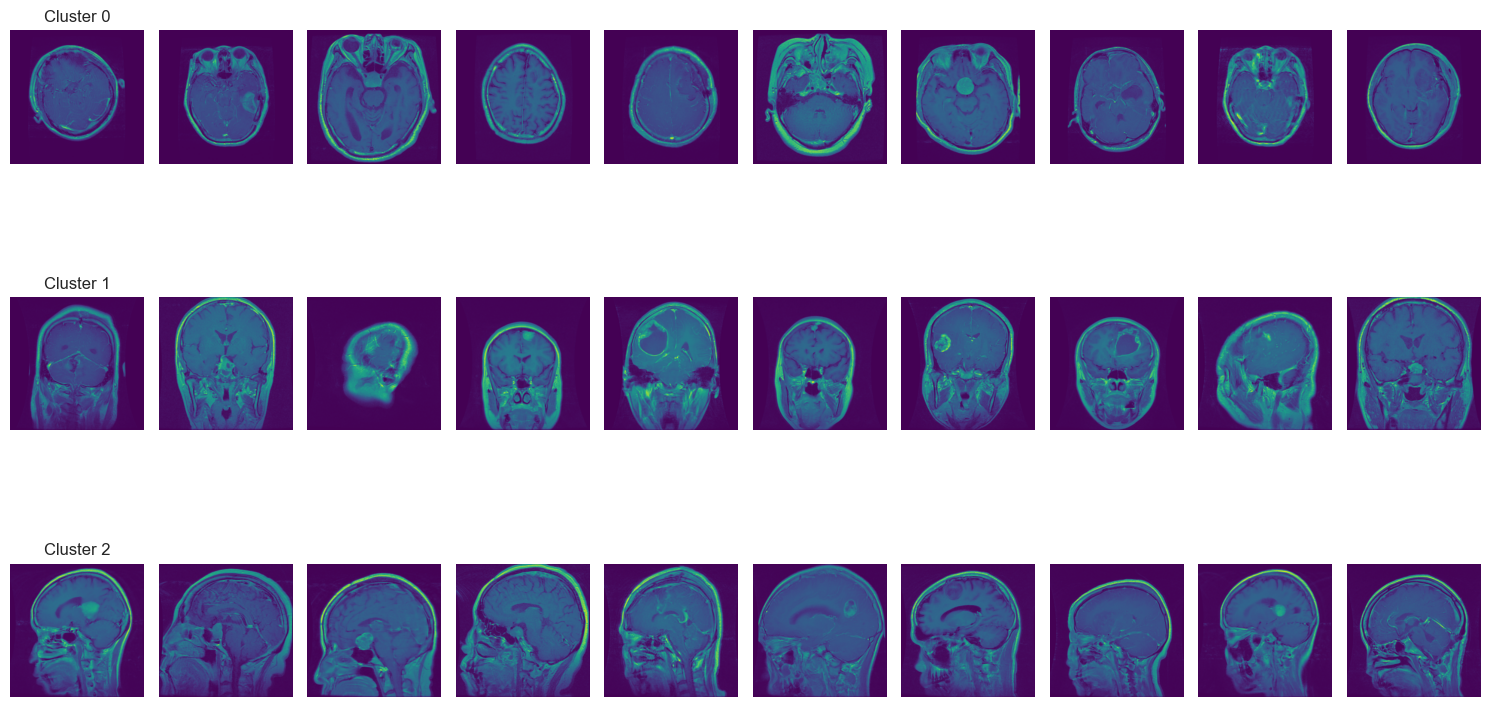

In [24]:
import matplotlib.pyplot as plt
import random

# Assuming you have the 'clusters' variable containing the cluster assignments
# Assuming you have the 'image_list' variable containing the original images

number_of_images = 10

fig, axs = plt.subplots(num_clusters, number_of_images, figsize=(15, num_clusters*3))

# Iterate over each cluster
for cluster_id in range(num_clusters):
    real_labels = []
    # Get the indices of images belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]

    # Randomly select five images from the cluster
    random_indices = random.sample(list(cluster_indices), number_of_images)

    # Iterate over the selected images
    for i, image_index in enumerate(random_indices):
        # Get the corresponding image array
        image_array = x_train[image_index]
        real_labels.append(y_train[image_index]) # DODAJ PRAWDZIWĄ LABELKE ABY SPRAWDZIĆ JAKOŚĆ GRUPOWANIA


        # Plot the image in the corresponding subplot
        ax = axs[cluster_id, i]
        ax.imshow(image_array)
        ax.axis('off')

    # Set the title for the cluster subplot
    axs[cluster_id, 0].set_title(f'Cluster {cluster_id}')
    print(f"Real labels{real_labels}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



In [22]:
clusters_reallabels = [[], [], []]

for cluster_id in range(num_clusters):
    real_labels = []
    # Get the indices of images belonging to the current cluster
    cluster_indices = np.where(clusters == cluster_id)[0]
    for x in cluster_indices:
        clusters_reallabels[cluster_id].append(y_train[x])

counts = [{"0": 0, "1": 0, "2": 0}, {"0": 0, "1": 0, "2": 0}, {"0": 0, "1": 0, "2": 0}]
for x in range(len(clusters_reallabels)):
    for _ in clusters_reallabels[x]:
        counts[x][str(_)] += 1

print(counts)



[{'0': 393, '1': 154, '2': 239}, {'0': 613, '1': 269, '2': 255}, {'0': 153, '1': 118, '2': 257}]


In [20]:
def custom_cluster_accuracy(counts, n_classes):

    percentages = [[], [], []]

    for idx, x in enumerate(percentages):
        suma = 0
        for s in range(n_classes):
            suma += counts[idx][str(s)]
        for i in range(n_classes):
             percentages[idx].append(counts[idx][str(i)] / suma)

    fi = n_classes*(1-1/n_classes+(n_classes-1)*1/n_classes)
    loss = fi

    for x in percentages:
        for i in x:
            loss -= abs(1/n_classes - i)

    print(f"Custom cluster accuracy 0-1: {round(1-loss/fi, 5)}")

In [21]:
custom_cluster_accuracy(counts, len(classes))

Custom cluster accuracy 0-1: 0.26294


In [33]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Assuming you have the 'data_array' containing your original image data
x, y = data_array

# Convert the feature array to a numpy array and normalize the pixel values
x = np.array(x) / 255.0

# Define a function to create masked versions of the input images
def create_masked_images(images):
    # Generate random binary masks
    masks = np.random.choice([0, 1], size=images.shape[:-1], p=[0.5, 0.5])
    # Apply the masks to the images
    masked_images = images * masks[..., np.newaxis]
    return masked_images, masks

# Create masked versions of the input images
masked_x, masks = create_masked_images(x)

# Create a TensorFlow Dataset from the data
dataset = tf.data.Dataset.from_tensor_slices((masked_x, x))

# Define and train a model to perform image inpainting (pretext task)
model = tf.keras.models.Sequential([
    # Encoder layers
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # Decoder layers
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model to reconstruct the original images from the masked versions
model.fit(dataset.batch(32), epochs=10)

# Extract the learned representations from the encoder part of the model
encoder = tf.keras.models.Model(inputs=model.input, outputs=model.layers[1].output)
representations = encoder.predict(x)

# The learned representations can now be used for downstream tasks such as clustering or classification


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [30]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]